<a href="https://colab.research.google.com/github/jardilam/MisionTIC/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

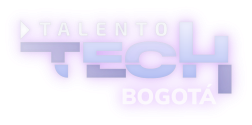

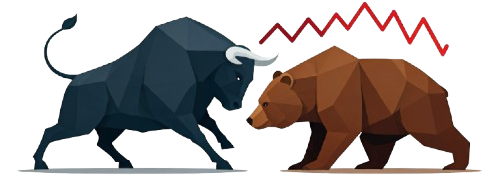

# Importamos las librerias a utilizar

In [3]:
!pip install pmdarima
!pip install seasonal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00


In [5]:
import yfinance as yf
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from seasonal import seasonal
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet


# Acá modifiqué Julio

In [ ]:
acciones = ["AAPL", "MSFT", "GOOG", "NVDA"]
#acciones = ["AAPL"]
inicio = "2004-01-01"
fin = datetime.today().strftime('%Y-%m-%d') #Establecemos como fecha de final para descargar los datos a la fecha de hoy.

# Descargar datos históricos
datos_historicos = []
consolidado_acciones = []
hist_por_accion = []

for accion in acciones:
    hist_por_accion = yf.download(accion, start=inicio, end=fin)
    hist_por_accion.columns = hist_por_accion.columns.get_level_values('Price')# Nos quedamos con las columnas del nivel Price de los 2 niveles de los datos obtenidos
    #hist_por_accion.columns = ["_".join(col).strip() if isinstance(col, tuple) else col for col in hist_por_accion.columns] #Esta línea convierte el MultiIndex en nombres de columna de una sola línea
    hist_por_accion = hist_por_accion.reset_index()  # Restablece el índice
    hist_por_accion["Simbolo"] = accion #Incluimos la columna acción
    datos_historicos.append(hist_por_accion)

consolidado_acciones = pd.concat(datos_historicos, ignore_index=True)
consolidado_acciones = pd.DataFrame(consolidado_acciones)
consolidado_acciones['Date'] = pd.to_datetime(consolidado_acciones['Date']).dt.date # Nos quedamos con el formato año-mes-día
consolidado_acciones['Date'] = pd.to_datetime(consolidado_acciones['Date'])

#Segmentamos el dataframe por trimestres, mes y semana
consolidado_acciones["Año"] = pd.DatetimeIndex(consolidado_acciones['Date']).year
consolidado_acciones["Trim"] = pd.DatetimeIndex(consolidado_acciones['Date']).quarter
consolidado_acciones["Mes"] = pd.DatetimeIndex(consolidado_acciones['Date']).month

# Renombramos las columnas
consolidado_acciones = consolidado_acciones.rename(columns={
    'Date': 'Fecha',
    'Open': 'Apertura',
    'High': 'Máximo',
    'Low': 'Mínimo',
    'Close': 'Cierre',
    'Adj Close': 'Cierre Ajustado',
    'Volume': 'Volumen'
})

consolidado_acciones = consolidado_acciones.set_index('Fecha')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Visualizamos el historico de precios
fig = px.line(consolidado_acciones, x=consolidado_acciones.index, y="Cierre Ajustado", color="Simbolo", title='Precio de Cierre de Acciones',template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre ajustado')
fig.show()

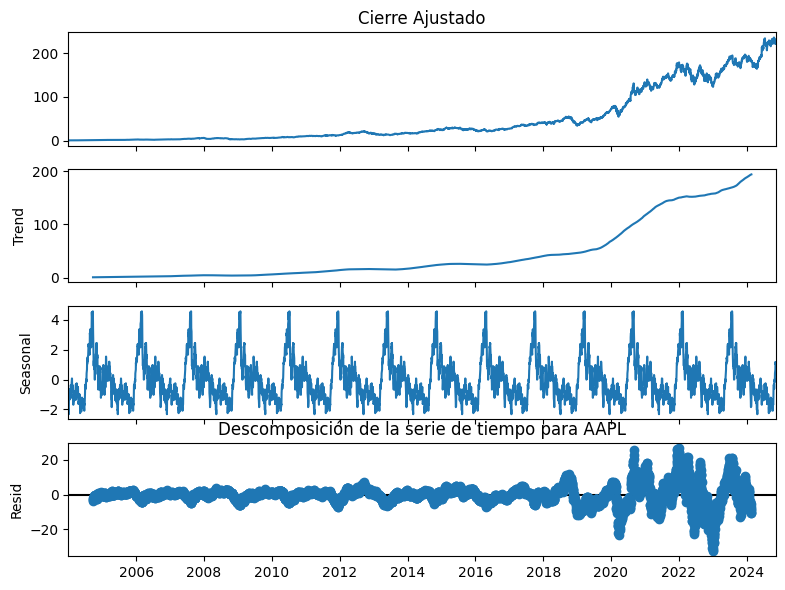

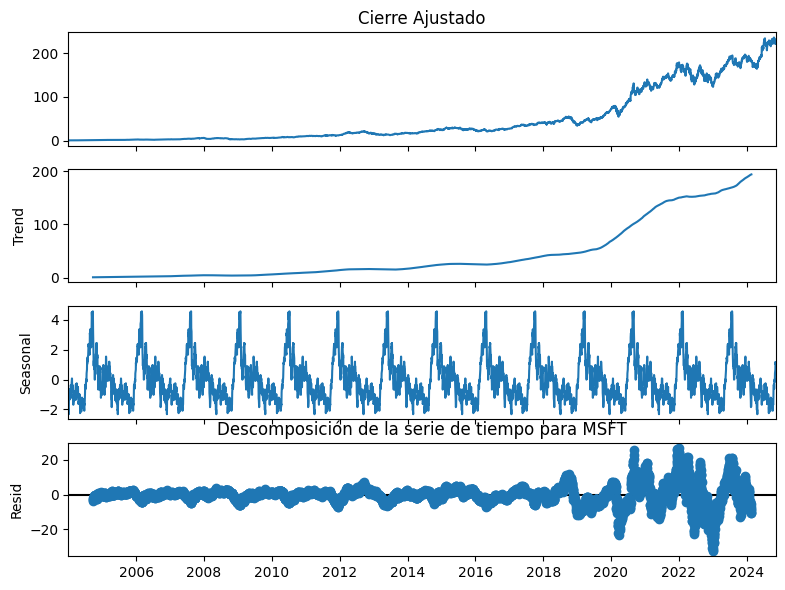

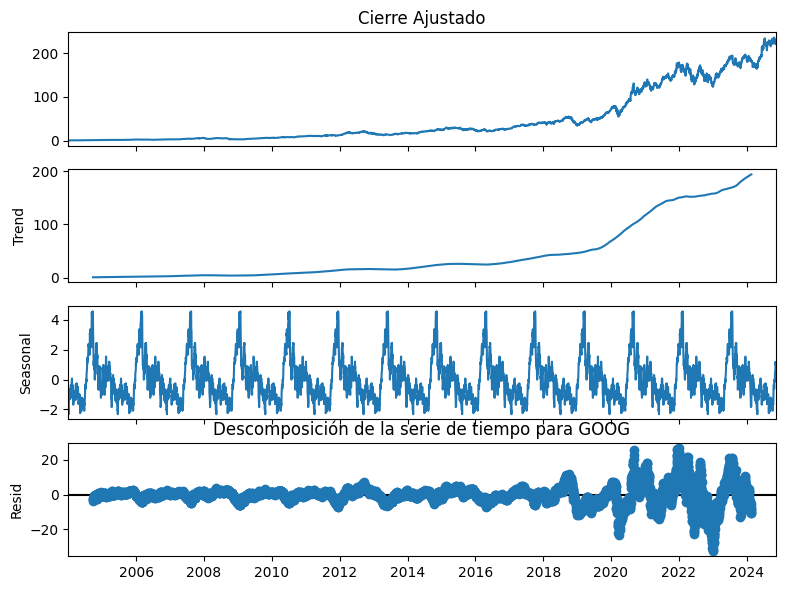

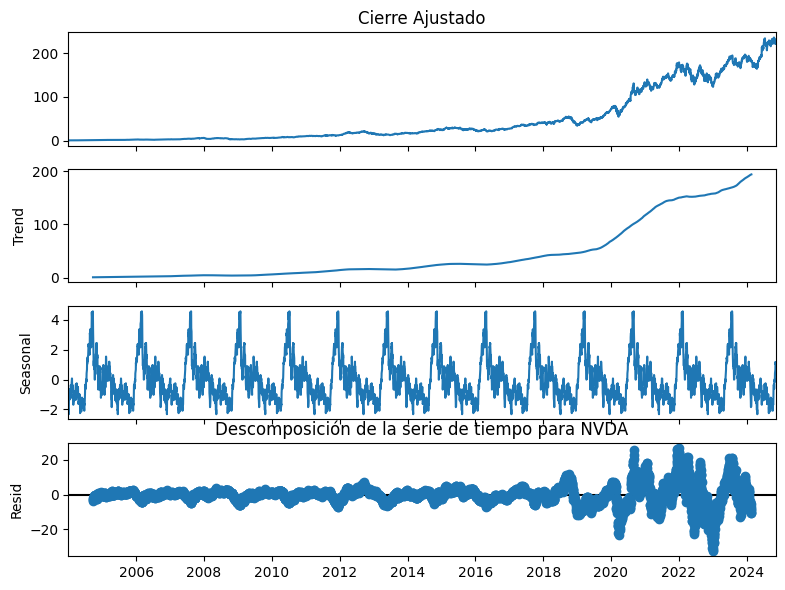

In [ ]:
# Descomposición de la serie de tiempo para cada acción
for accion in acciones:
  datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]['Cierre Ajustado']
  result = seasonal_decompose(df_aapl['Cierre Ajustado'], model='additive', period=365)

  # Graficar la descomposición
  plt.rcParams.update({'figure.figsize': (8, 6)})
  result.plot()
  plt.title(f"Descomposición de la serie de tiempo para {accion}")
  plt.show()

In [ ]:
consolidado_acciones['Fecha2'] = consolidado_acciones.index
consolidado_acciones['Cierre ajustado mensual'] = consolidado_acciones.groupby(['Simbolo', pd.Grouper(key='Fecha2', freq='MS')])['Cierre Ajustado'].transform('last')

consolidado_acciones_mensual = consolidado_acciones[['Fecha2','Simbolo','Cierre ajustado mensual']].drop_duplicates()
consolidado_acciones_mensual = consolidado_acciones_mensual.sort_values(['Simbolo','Fecha2'])

# Visualizamos el historico de precios mensual
fig = px.line(consolidado_acciones_mensual, x=consolidado_acciones.index, y="Cierre ajustado mensual", color="Simbolo", title='Precio de Cierre de Acciones Ajustado Mensual',template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()
consolidado_acciones = consolidado_acciones.drop(columns=['Fecha2'])

In [ ]:
#Evaluación de modelos

import numpy as np
from sklearn import metrics
from sklearn.metrics import r2_score
def evaluacion_modelo(y_true, y_pred):

    def men_abs_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) *100
    #print('Evaluación del modelo: \n')
    print('MSE = ', metrics.mean_squared_error(y_true, y_pred))
    print('MAE = ', metrics.mean_absolute_error(y_true, y_pred))
    print('RMSE =', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('MAPE = ', men_abs_percentage_error(y_true, y_pred))
    print(f'R2 = {r2_score(y_true, y_pred)}')

## Modelo SARIMAX

In [ ]:
accion_a_filtrar = "AAPL"  # Reemplaza con la acción que deseas filtrar ['AAPL', 'MSFT', 'GOOG', 'NVDA']

In [ ]:
bd_modelos = consolidado_acciones.copy()
bd_modelos = bd_modelos[bd_modelos['Simbolo'] == accion_a_filtrar]
bd_sarimax = bd_modelos.copy()

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba (95% entrenamiento, 5% prueba)
ventanas = 30

train_data_SA, test_data_SA = train_test_split(bd_sarimax[['Cierre Ajustado']],  test_size=0.05, random_state=42, shuffle=False) # El argumento shuffle=False asegura que la división se realice de manera secuencial sin revolver los datos.

train_data_dias = pd.DataFrame(train_data_SA)
test_data_dias = pd.DataFrame(test_data_SA)

print(f"Tamaño de datos de entrenamiento: {len(train_data_SA)} <--> {len(train_data_SA)*100/len(bd_sarimax):.0f} %")
print(f"Tamaño de datos de prueba: {len(test_data_SA)} <--> {len(test_data_SA)*100/len(bd_sarimax):.0f} %")

Tamaño de datos de entrenamiento: 5220 <--> 99 %
Tamaño de datos de prueba: 30 <--> 1 %


In [ ]:
# Ajustar el modelo ARIMA automático
model_auto = pm.auto_arima(train_data_dias, start_p=0, q=0,
                      test='adf',       # Ajusta el mejor valor para d aplicando la prueba Augmented Dickey Fuller
                      max_p=3, max_q=3, # maximos valores para p y q
                      m=365,              # Frecuencia de la serie de tiempo
                      d=None,           # El modelo determina d
                      seasonal=False,   # Serie de tiempo no estacional
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# Imprimir el resumen del modelo
print(model_auto.summary())

Tamaño de datos de entrenamiento: 4987 <--> 95 %
Tamaño de datos de prueba: 263 <--> 5 %
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (365) set for non-seasonal fit. Setting to 0



 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15957.601, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15964.683, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15960.242, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15959.846, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15966.810, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15958.665, Time=1.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15958.103, Time=1.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15957.453, Time=9.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15958.603, Time=6.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15958.076, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15887.796, Time=14.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=14.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15939.607, Time=5.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15959.814, Time=4.12 sec
 ARI

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

sarimax_model = SARIMAX(train_data_dias, order=(2,1,2),seasonal_order=(0,0,0,0)).fit()

SA_predicción = sarimax_model.predict(start= len(train_data_SA), end = len(bd_sarimax)-1, typ='levels').rename('SA_predicción')
SA_predicción = pd.DataFrame(SA_predicción)
SA_predicción.index = test_data_SA.index

Resultado = test_data_dias.copy()
Resultado['SA_predicción'] = SA_predicción['SA_predicción']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginnin

In [ ]:
#Creamos el dataframe con los datos a visualizar
df_plot = pd.DataFrame({'Real': bd_sarimax['Cierre Ajustado'], 'SA_predicción': SA_predicción['SA_predicción']})

# Create the plot using Plotly Express
fig = px.line(df_plot, x=bd_sarimax.index, y=['Real','SA_predicción'], title='Predicciones vs. Datos Reales', template='plotly_dark') # Use df_plot.index for x
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()

# **Modelo RANDOM FOREST**

In [ ]:
bd_random_forest = bd_modelos.copy()
bd_random_forest = pd.DataFrame(bd_random_forest['Cierre Ajustado'])

bd_random_forest['porcentaje_cambio'] = bd_random_forest['Cierre Ajustado'].pct_change()
bd_random_forest = bd_random_forest.dropna()

In [ ]:
# Estandarizamos el modelo
dias = 30 #Cantidad de dias de retraso
i = 1
# Generar datos retrasados para la columna 'Cierre Ajustado"
for i in range(1, dias):
    bd_random_forest[f'Close_lag_{i}'] = bd_random_forest['Cierre Ajustado'].shift(i)

bd_rf = bd_random_forest.dropna()
# Mostrar las primeras filas del DataFrame con los datos retrasados
print(bd_random_forest.tail(30))

            Cierre Ajustado  porcentaje_cambio  Close_lag_1  Close_lag_2  \
Fecha                                                                      
2024-09-30       232.743942           0.022872   227.539658   227.269958   
2024-10-01       225.961411          -0.029142   232.743942   227.539658   
2024-10-02       226.530777           0.002520   225.961411   232.743942   
2024-10-03       225.421982          -0.004895   226.530777   225.961411   
2024-10-04       226.550751           0.005007   225.421982   226.530777   
2024-10-07       221.446365          -0.022531   226.550751   225.421982   
2024-10-08       225.521881           0.018404   221.446365   226.550751   
2024-10-09       229.287735           0.016698   225.521881   221.446365   
2024-10-10       228.788284          -0.002178   229.287735   225.521881   
2024-10-11       227.299927          -0.006505   228.788284   229.287735   
2024-10-14       231.045807           0.016480   227.299927   228.788284   
2024-10-15  

In [ ]:
#Modelación
X2 = bd_rf.iloc[:,2:]
y2 = bd_rf.iloc[:,1]

Y2 = y2
train_target_size = len(train_data_SA)-60
train_target, test_target = Y2[0:train_target_size], Y2[train_target_size:len(Y2)]

print(f"Observaciones para el objetivo:: {len(Y2)}")
print(f"Observaciones de entrenamiento para el objetivo: {len(train_target)}")
print(f"Observaciones de prueba para el objetivo: {len(test_target)}\n")

train_features_size = len(train_data_SA)-60
train_features, test_features = X2[:train_features_size], X2[train_features_size:len(X2)]
print(f'Observaciones para la característica: %d' % (len(X2)))
print(f"Observaciones de entrenamiento para la característica: %d" % (len(train_features)))
print(f"Observaciones de prueba para la característica: {len(test_features)}")

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=210,  shuffle=False)

Observaciones para el objetivo:: 5190
Observaciones de entrenamiento para el objetivo: 5160
Observaciones de prueba para el objetivo: 30

Observaciones para la característica: 5190
Observaciones de entrenamiento para la característica: 5160
Observaciones de prueba para la característica: 30


In [ ]:
#Ejecutamos la predicción con Random Forest
Semilla = 42

rfr = RandomForestRegressor(n_estimators=500, random_state=Semilla)

rfr.fit(train_features, train_target)

rf_forescast = rfr.predict(test_features)

In [ ]:
rf_forescast.shape

(263,)

In [ ]:
pred_ramdom=np.r_[Resultado['Cierre Ajustado'].iloc[0],rf_forescast[1:]].cumsum().astype(float)
Resultado['RF_Predicciones'] = pred_ramdom

In [ ]:
fig = px.line(Resultado, x=Resultado.index, y=['Cierre Ajustado', 'SA_predicción','RF_Predicciones'],
             title='Comparación de Predicciones con Datos Reales (Test Data)', template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()

## **Modelo PROPHET**

In [ ]:
bd_prophet = bd_modelos['Cierre Ajustado']
bd_prophet = bd_prophet.reset_index()
bd_prophet = bd_prophet.rename(columns={'Fecha': 'ds', 'Cierre Ajustado': 'y'})

In [ ]:
test_Prophet = len(test_data_dias)
train_Prophet = len(bd_prophet)-test_Prophet
train_Prophet, test_Prophet

train_data_prophet = bd_prophet.iloc[:train_Prophet, :]
test_data_prophet = bd_prophet.iloc[train_Prophet:, :]
train_data_prophet.shape, test_data_prophet.shape

m = Prophet()
m.fit(train_data_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplp6z2wp1/egl8lzas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplp6z2wp1/sqp5llvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93661', 'data', 'file=/tmp/tmplp6z2wp1/egl8lzas.json', 'init=/tmp/tmplp6z2wp1/sqp5llvr.json', 'output', 'file=/tmp/tmplp6z2wp1/prophet_modeljkj2905b/prophet_model-20241111073503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=len(test_data_prophet), freq='D')
prophet_pred = m.predict(future)
prophet_pred = pd.DataFrame({"Date":prophet_pred[-len(test_data_prophet):]["ds"], "Prophet_predicciones":prophet_pred[-len(test_data_prophet):]["yhat"]})
prophet_pred.set_index("Date", inplace=True)
Resultado['PP_predicciones'] = prophet_pred['Prophet_predicciones'].values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263 entries, 2023-10-25 to 2024-11-08
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cierre Ajustado  263 non-null    float64
 1   SA_predicción    263 non-null    float64
 2   RF_Predicciones  263 non-null    float64
 3   PP_predicciones  263 non-null    float64
dtypes: float64(4)
memory usage: 18.4 KB


In [ ]:
fig = px.line(Resultado, x=Resultado.index, y=['Cierre Ajustado', 'SA_predicción','RF_Predicciones','PP_predicciones'],
             title='Comparación de Predicciones con Datos Reales (Test Data)', template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()

In [ ]:
print("Evaluación del modelo SARIMAX")
ev_SA = evaluacion_modelo(Resultado['Cierre Ajustado'], Resultado['SA_predicción'])

print("\nEvaluación del modelo RANDOM FOREST")
ev_RF = evaluacion_modelo(Resultado['Cierre Ajustado'], Resultado['RF_Predicciones'])

print("\nEvaluación del modelo PROPHET")
ev_PP = evaluacion_modelo(Resultado['Cierre Ajustado'], Resultado['PP_predicciones'])

Evaluación del modelo SARIMAX
MSE =  1166.4719046419812
MAE =  27.299083844840652
RMSE = 34.15365141009056
MAPE =  12.791531372750043
R2 = -1.4644400945056528

Evaluación del modelo RANDOM FOREST
MSE =  1368.7956862498058
MAE =  29.758662611668846
RMSE = 36.99723890035317
MAPE =  13.95550449451633
R2 = -1.8918956015625206

Evaluación del modelo PROPHET
MSE =  315.04609046698897
MAE =  15.341253520083262
RMSE = 17.74953775361457
MAPE =  7.886372566291626
R2 = 0.33439269829443286
